In [192]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [193]:
store_df = pd.read_csv('./rossmann-store-sales/store.csv')
train_df = pd.read_csv('./rossmann-store-sales/train.csv', parse_dates=['Date'])
test_df = pd.read_csv('./rossmann-store-sales/test.csv', parse_dates=['Date'])

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_19316\1276205017.py:2: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  train_df = pd.read_csv('./rossmann-store-sales/train.csv', parse_dates=['Date'])


In [194]:
print(f"Train shape: {train_df.shape}, Store shape: {store_df.shape}, Test shape: {test_df.shape}")

Train shape: (1017209, 9), Store shape: (1115, 10), Test shape: (41088, 8)


In [195]:
train_df.columns
store_df.columns

Index(['Store', 'StoreType', 'Assortment', 'CompetitionDistance',
       'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

* **Id**: ID duy nhất đại diện cho cặp (Store, Date) trong tập kiểm thử.
* **Store**: Mã định danh duy nhất của từng cửa hàng.
* **Date**: Ngày cụ thể của bản ghi (định dạng `YYYY-MM-DD`).

---


* **Sales**: Doanh thu (turnover) của cửa hàng trong ngày — **biến mục tiêu cần dự đoán**.
* **Customers**: Số lượng khách hàng ghé cửa hàng trong ngày (chỉ có trong train set).
* **Open**: Trạng thái cửa hàng: `1 = mở`, `0 = đóng`. Nếu `Open=0` thì `Sales=0`.

---


* **StateHoliday**: Cho biết ngày đó có phải **ngày lễ chính thức** hay không:

  * `a` = lễ công cộng (Public holiday)
  * `b` = lễ Phục Sinh (Easter holiday)
  * `c` = lễ Giáng Sinh (Christmas)
  * `0` = không phải ngày lễ
* **SchoolHoliday**: Cho biết **trường học có nghỉ** hay không (`1 = nghỉ`, `0 = không`).

---


* **StoreType**: Loại cửa hàng (mô hình hoạt động): `a`, `b`, `c`, `d`.
* **Assortment**: Mức độ đa dạng hàng hóa:

  * `a` = cơ bản
  * `b` = mở rộng
  * `c` = cao cấp
* **CompetitionDistance**: Khoảng cách (tính bằng mét) đến cửa hàng đối thủ gần nhất.
* **CompetitionOpenSinceMonth**: Tháng mà cửa hàng đối thủ gần nhất bắt đầu hoạt động.
* **CompetitionOpenSinceYear**: Năm mà cửa hàng đối thủ gần nhất bắt đầu hoạt động.

---

* **Promo**: Cửa hàng có đang chạy **khuyến mãi ngắn hạn** hay không (`1 = có`, `0 = không`).
* **Promo2**: Cửa hàng có tham gia **chương trình khuyến mãi dài hạn, định kỳ (liên tục)** hay không (`1 = có`, `0 = không`).
* **Promo2SinceYear**: Năm cửa hàng bắt đầu tham gia chương trình **Promo2**.
* **Promo2SinceWeek**: Tuần trong năm cửa hàng bắt đầu tham gia chương trình **Promo2**.
* **PromoInterval**: Các tháng trong năm mà chương trình **Promo2** được tái khởi động.

  * Ví dụ: `"Feb,May,Aug,Nov"` nghĩa là mỗi đợt promo bắt đầu lại vào tháng 2, 5, 8, 11.



In [196]:
train_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


<Axes: xlabel='Sales', ylabel='Count'>

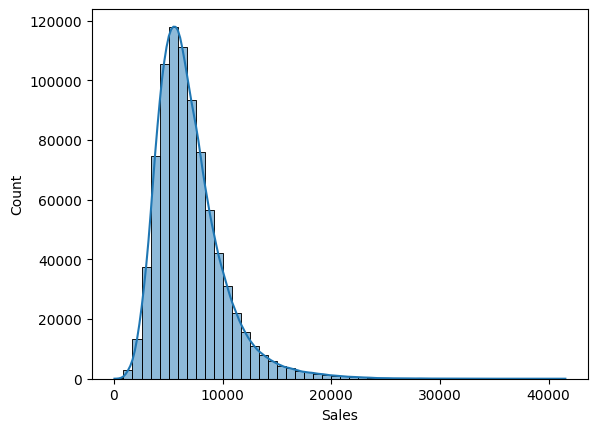

In [212]:
sns.histplot(train_df["Sales"], bins=50, kde=True)


In [197]:
store_df.head()

,Store,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN


In [198]:
# Remove closed days or days with no sales
train_df = train_df[(train_df["Sales"] > 0)]

In [199]:
# Fill missing values in store_df
store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].mean(), inplace=True)
store_df["CompetitionOpenSinceMonth"].fillna(0, inplace=True)
store_df["CompetitionOpenSinceYear"].fillna(0, inplace=True)
store_df["Promo2SinceWeek"].fillna(0, inplace=True)
store_df["Promo2SinceYear"].fillna(0, inplace=True)
store_df["PromoInterval"].fillna("None", inplace=True)

C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_19316\3576865565.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  store_df["CompetitionDistance"].fillna(store_df["CompetitionDistance"].mean(), inplace=True)
C:\Users\HP VICTUS\AppData\Local\Temp\ipykernel_19316\3576865565.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we a

In [200]:
merged_df = pd.merge(train_df, store_df, on="Store", how="left")
merged_df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,0.0,0.0,None
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,0.0,0.0,None
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,0.0,0.0,None


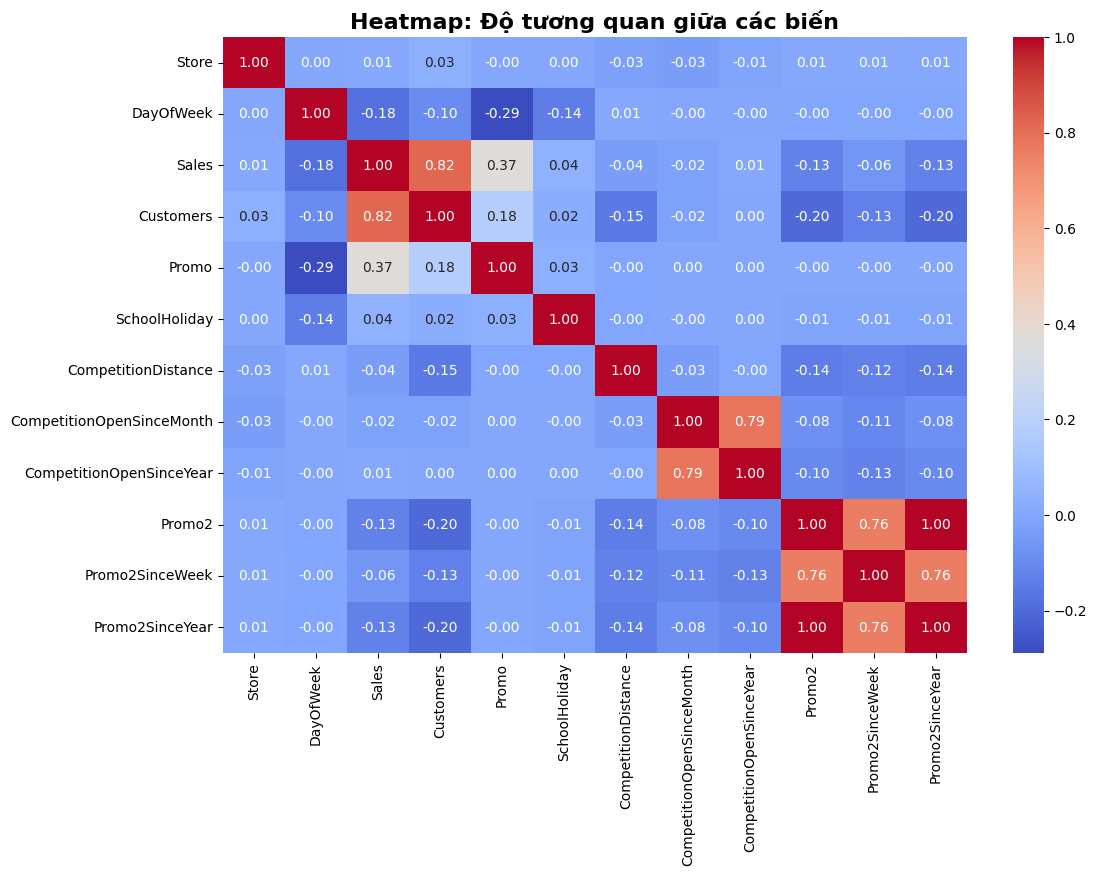

In [201]:
# Lọc các cột số
numeric_df = merged_df.select_dtypes(include=[np.number])

# Bỏ biến 'Open'
if 'Open' in numeric_df.columns:
    numeric_df.drop(columns=['Open'], inplace=True)

# Tính ma trận tương quan
correlation_matrix = numeric_df.corr()

# Vẽ heatmap
plt.figure(figsize=(12, 8))  # Tăng kích thước để dễ nhìn hơn
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Heatmap: Độ tương quan giữa các biến", fontsize=16, fontweight='bold')
plt.show()

In [202]:
merged_df['Open'].value_counts()

Open
1    844338
Name: count, dtype: int64

In [203]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 844338 entries, 0 to 844337
Data columns (total 18 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   Store                      844338 non-null  int64         
 1   DayOfWeek                  844338 non-null  int64         
 2   Date                       844338 non-null  datetime64[ns]
 3   Sales                      844338 non-null  int64         
 4   Customers                  844338 non-null  int64         
 5   Open                       844338 non-null  int64         
 6   Promo                      844338 non-null  int64         
 7   StateHoliday               844338 non-null  object        
 8   SchoolHoliday              844338 non-null  int64         
 9   StoreType                  844338 non-null  object        
 10  Assortment                 844338 non-null  object        
 11  CompetitionDistance        844338 non-null  float64 

In [204]:
merged_df.isna().sum()

Store                        0
DayOfWeek                    0
Date                         0
Sales                        0
Customers                    0
Open                         0
Promo                        0
StateHoliday                 0
SchoolHoliday                0
StoreType                    0
Assortment                   0
CompetitionDistance          0
CompetitionOpenSinceMonth    0
CompetitionOpenSinceYear     0
Promo2                       0
Promo2SinceWeek              0
Promo2SinceYear              0
PromoInterval                0
dtype: int64

## **Feature Extraction**

In [205]:
def split_date(df):
    df["Year"] = df.Date.dt.year
    df["Month"] = df.Date.dt.month
    df["Day"] = df.Date.dt.day
    df["WeekOfYear"] = df.Date.dt.isocalendar().week
    return df

def comp_months(df):
    df["CompetitionOpen"] = 12 * (df.Year - df.CompetitionOpenSinceYear) + (df.Month - df.CompetitionOpenSinceMonth)
    df["CompetitionOpen"] = df["CompetitionOpen"].map(lambda x: 0 if x < 0 else x).fillna(0)
    return df

def check_promo_month(row):
    month2str = {1:'Jan', 2:'Feb', 3:'Mar', 4:'Apr', 5:'May', 6:'Jun',      
                 7:'Jul', 8:'Aug', 9:'Sept', 10:'Oct', 11:'Nov', 12:'Dec'}
    try:
        months = (row['PromoInterval'] or '').split(',')
        if row['Promo2Open'] and month2str[row['Month']] in months:
            return 1
        else:
            return 0
    except Exception:
        return 0

def promo_cols(df):
    df["Promo2Open"] = 12 * (df.Year - df.Promo2SinceYear) + (df.WeekOfYear - df.Promo2SinceWeek) * 7 / 30.5
    df["Promo2Open"] = df["Promo2Open"].map(lambda x: 0 if x < 0 else x).fillna(0) * df["Promo2"]
    df["IsPromo2Month"] = df.apply(check_promo_month, axis=1) * df["Promo2"]
    return df

In [206]:
merged_df = split_date(merged_df)
merged_df = comp_months(merged_df)
merged_df = promo_cols(merged_df)

In [207]:
cat_features = ["StoreType", "Assortment", "StateHoliday"]
le = LabelEncoder()
for col in cat_features:
    merged_df[col] = le.fit_transform(merged_df[col].astype(str))

# Scale numerical features
num_features = ["Sales", "Customers", "CompetitionDistance", "CompetitionOpen", "Promo2Open"]
scaler = StandardScaler()
merged_df[num_features] = scaler.fit_transform(merged_df[num_features])

In [208]:
merged_df.drop(["Date", "PromoInterval"], axis=1, inplace=True)

In [209]:
merged_df.head()

,Store,DayOfWeek,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,...,Promo2,Promo2SinceWeek,Promo2SinceYear,Year,Month,Day,WeekOfYear,CompetitionOpen,Promo2Open,IsPromo2Month
0,1,5,-0.545445,-0.517897,1,1,0,1,2,0,...,0,0.0,0.0,2015,7,31,31,-0.681199,-0.686973,0
1,2,5,-0.287375,-0.343418,1,1,0,1,0,0,...,1,13.0,2010.0,2015,7,31,31,-0.680308,2.690576,1
2,3,5,0.437539,0.145124,1,1,0,1,0,0,...,1,14.0,2011.0,2015,7,31,31,-0.679329,2.046494,1
3,4,5,2.267868,1.832587,1,1,0,1,2,2,...,0,0.0,0.0,2015,7,31,31,-0.682267,-0.686973,0
4,5,5,-0.687528,-0.507927,1,1,0,1,0,0,...,0,0.0,0.0,2015,7,31,31,-0.688234,-0.686973,0


In [210]:
merged_df.to_csv("cleaned_data.csv", index=False)
print("\n💾 cleaned_data.csv has been successfully saved!")
print("✅ Shape:", merged_df.shape)
print("📈 Columns:", list(merged_df.columns))


💾 cleaned_data.csv has been successfully saved!
✅ Shape: (844338, 23)
📈 Columns: ['Store', 'DayOfWeek', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'Year', 'Month', 'Day', 'WeekOfYear', 'CompetitionOpen', 'Promo2Open', 'IsPromo2Month']


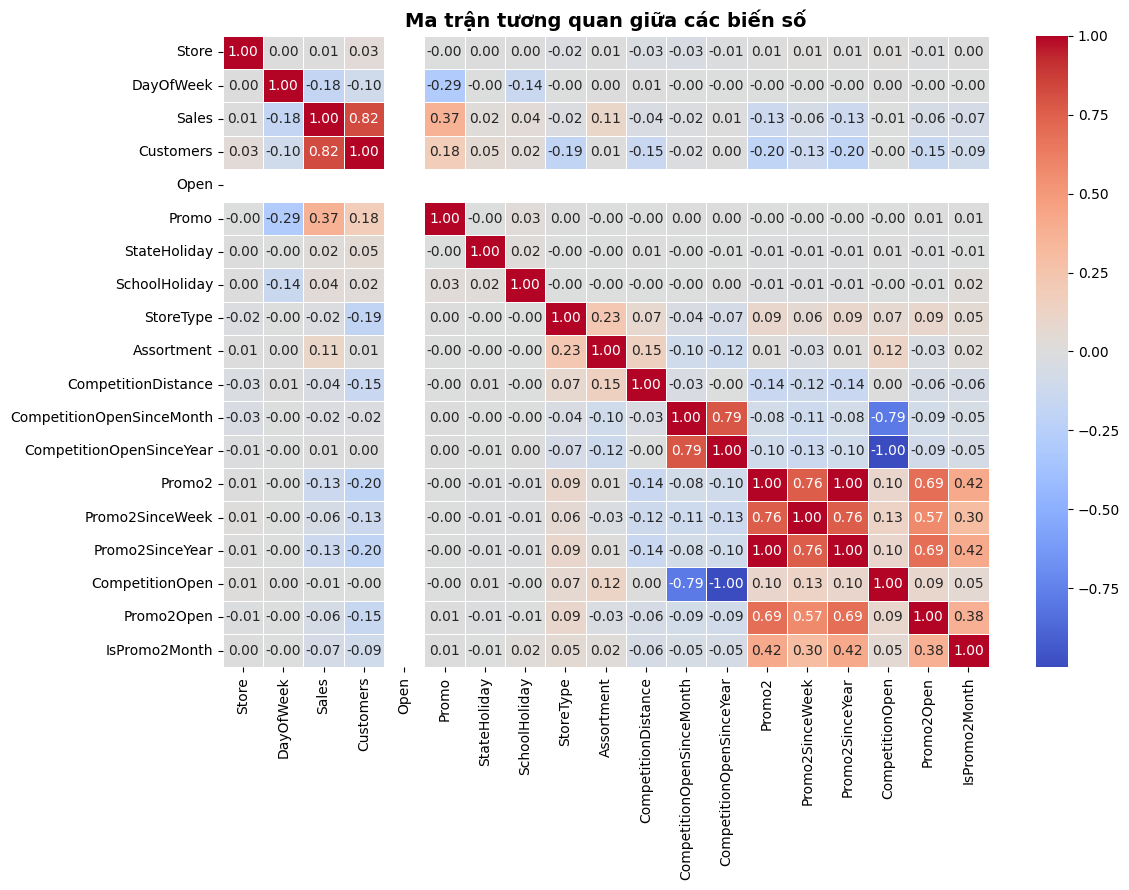

In [211]:
# --- 1. Heatmap tương quan giữa các biến số ---
plt.figure(figsize=(12, 9))
numeric_cols = merged_df.select_dtypes(include=['int64', 'float64']).columns
corr = merged_df[numeric_cols].corr()
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True, fmt=".2f", linewidths=0.5)
plt.title("Ma trận tương quan giữa các biến số", fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()